In [16]:
# Load data

import unidecode

headlines = list()
with open('data/headlines.txt') as f:
    for line in f:
        headline_norm = unidecode.unidecode(line[:-1].lower())  # remove accents with unidecode                                                            
        headlines.append(headline_norm)                         # and newline character

# Take a look at first 10 headlines
        
print(headlines[:10])

['zika outbreak hits miami', 'could zika reach new york city?', 'first case of zika in miami beach', 'mystery virus spreads in recife, brazil', 'dallas man comes down with case of zika', 'trinidad confirms first zika case', 'zika concerns are spreading in houston', 'geneve scientists battle to find cure', 'the cdc in atlanta is growing worried', 'zika infested monkeys in sao paulo']


In [17]:
# Create list of country and city names from geonamescache

import geonamescache

gc = geonamescache.GeonamesCache()

countries = []
countries_dic = gc.get_countries()

for key in countries_dic:
    countries.append(unidecode.unidecode(countries_dic[key]['name']))
    

countries.sort(key = len, reverse = True) # sort longest to shortest to avoid regex finding partial match

# Dictionary mapping unaccented country name to accented country name

country_accented_names = {unidecode.unidecode(country['name']): country['name'] 
                          for country in countries_dic.values() 
                          if country['name'] != unidecode.unidecode(country['name'])}

cities = []
cities_dic = gc.get_cities() 

for key in cities_dic:
    cities.append(unidecode.unidecode(cities_dic[key]['name']))
    
cities.sort(key = len, reverse = True) # sort longest to shortest to avoid regex finding partial match

# Dictionary mapping unaccented city name to accented city name

city_accented_names = {unidecode.unidecode(city['name']): city['name'] 
                       for city in cities_dic.values() 
                       if city['name'] != unidecode.unidecode(city['name'])}


# Take a look at first ten cities, countries, and accented names

print('Countries: ', countries[:10], '\n')
print('Cities: ', cities[:10], '\n')
print('Accented City Names: ', list(city_accented_names.values())[:10], '\n')
print('Accented Country Names: ', list(country_accented_names.values())[:10], '\n')


Countries:  ['South Georgia and the South Sandwich Islands', 'United States Minor Outlying Islands', 'Bonaire, Saint Eustatius and Saba ', 'Heard Island and McDonald Islands', 'Democratic Republic of the Congo', 'Saint Vincent and the Grenadines', 'British Indian Ocean Territory', 'French Southern Territories', 'Saint Pierre and Miquelon', 'Central African Republic'] 

Cities:  ['Chak Two Hundred Forty-nine Thal Development Authority', 'Dolores Hidalgo Cuna de la Independencia Nacional', 'Ampliacion San Mateo (Colonia Solidaridad)', 'Licenciado Benito Juarez (Campo Gobierno)', 'Sant Pere, Santa Caterina i La Ribera', 'Palikir - National Government Center', 'Nanchital de Lazaro Cardenas del Rio', 'San Fernando del Valle de Catamarca', "el Camp d'en Grassot i Gracia Nova", 'San Martin Texmelucan de Labastida'] 

Accented City Names:  ['Khawr Fakkān', 'Shīnḏanḏ', 'Shibirghān', 'Sang-e Chārak', 'Aībak', 'Rustāq', 'Qarqīn', 'Qarāwul', 'Pul-e Khumrī', 'Paghmān'] 

Accented Country Names:  []

In [18]:
# Check headlines for city and country

import re
import pandas as pd

# Create regex for countries 
country_reg_ex = ''
for place in countries:
    country_reg_ex += r'\b' + re.escape(place) +r'\b|' #\b to match entire place name
    
country_reg_ex = country_reg_ex[:-1]

# Look at first 100 characters in country_reg_ex

print('Country regex: ', country_reg_ex[:100])

country_reg_ex = re.compile(country_reg_ex, re.I)

# Create regex for countries 
city_reg_ex = r''
for place in cities:
    city_reg_ex +=r'\b' + re.escape(place) + r'\b|' #\b to match entire place name
    
city_reg_ex = city_reg_ex[:-1]+r'\b'

# Look at first 100 characters in city_reg_ex
print('City regex: ', city_reg_ex[:100])

city_reg_ex = re.compile(city_reg_ex,re.I)

headline_place_data = [['headline','city', 'country']]

for headline in headlines:
    countries_match = country_reg_ex.findall(headline)
    cities_match = city_reg_ex.findall(headline)
    if countries_match == []:
        country = ''
    else:
        countries_match.sort(key = len, reverse = True)
        country = countries_match[0].title()
        
    if cities_match == []:
        city = ''
    else:
        cities_match.sort(key = len, reverse = True)
        city = cities_match[0].title()
    headline_place_data.extend([[headline, city, country]])

headline_df = pd.DataFrame(headline_place_data[1:], columns=headline_place_data[0])

Country regex:  \bSouth\ Georgia\ and\ the\ South\ Sandwich\ Islands\b|\bUnited\ States\ Minor\ Outlying\ Islands\b|
City regex:  \bChak\ Two\ Hundred\ Forty\-nine\ Thal\ Development\ Authority\b|\bDolores\ Hidalgo\ Cuna\ de\ la\ 


In [19]:
# Check for common city names
headline_df.groupby('city').count().sort_values('headline', ascending=False).head(5) 
# shows cities incorrectly detected as 'hit', 'of' and 'come'

,headline,country
city,,
,31,31
Of,6,6
Monroe,4,4
Miami,4,4
Madrid,4,4


In [21]:
# Remove cities detected as 'hit', 'of' and 'come'
mask =(headline_df['city'] == 'Hit') | (headline_df['city'] =='Of' )|  (headline_df['city'] =='Come')

headline_df.loc[mask, 'city'] = ''

In [22]:
def find_largest_city_pop(city_dict):
    '''Returns geonameid of city in city_dict with largest population
    city_dict: subset of GeoNamesCache.get_cities()'''
    max_pop = -1
    if city_dict == []:
        return ''
    for city in city_dict:
        for key in city:
            if city[key]['population'] > max_pop:
                largest = city[key]['geonameid']
    return str(largest)

def restore_accent(city):
    if city in city_accented_names.keys():
        return city_accented_names[city]
    return city

def get_lon(geonameid):
    '''Returns longitude of city in gc.get_cities with geonameid = geonameid'''
    if geonameid == '':
        return ''                            
    return gc.get_cities()[geonameid]['longitude']

def get_lat(geonameid):
    '''Returns latitude of city in gc.get_cities with geonameid = geonameid'''
    if geonameid == '':
        return ''                            
    return gc.get_cities()[geonameid]['latitude']

def get_countrycode(geonameid):
    '''Returns countrycode in gc.get_cities with geonameid = geonameid'''
    if geonameid == '':
        return ''                            
    return gc.get_cities()[geonameid]['countrycode']

# Create long, lat, country code columns given city

mask = headline_df['city'].map(gc.get_cities_by_name).str.len() == 0
headline_df.loc[mask, 'city'] = headline_df.loc[mask, 'city'].map(restore_accent)

headline_df['longitude'] = headline_df['city'].map(gc.get_cities_by_name).map(find_largest_city_pop).map(get_lon)
headline_df['latitude'] = headline_df['city'].map(gc.get_cities_by_name).map(find_largest_city_pop).map(get_lat)
headline_df['country code'] = headline_df['city'].map(gc.get_cities_by_name).map(find_largest_city_pop).map(get_countrycode)

headline_df = headline_df[headline_df['longitude']!='']

In [23]:
# Check basic counts
headline_df.describe()

,headline,city,country,longitude,latitude,country code
count,607,607,607,607.00000,607.00000,607
unique,605,572,11,572.00000,572.00000,88
top,spanish flu outbreak in lisbon,Monroe,,-3.70256,25.77427,US
freq,2,4,592,4.00000,4.00000,346


In [24]:
# Remove Duplicate headlines:
dup_rows = [headline_df[headline_df['headline'] == 'spanish flu spreading through madrid'].index[0],
            headline_df[headline_df['headline'] == 'spanish flu outbreak in lisbon'].index[0]]
headline_df = headline_df.drop(dup_rows)

Text(0.5, 1.0, 'Distribution of Disease')

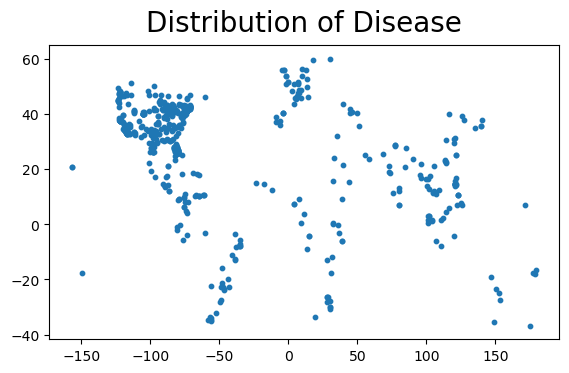

In [50]:
import matplotlib.pyplot as plt

fig = plt.figure(figsize=(7.5, 7.5))

ax = fig.add_axes([0.2, 0.17, 0.68, 0.7], aspect=2)
ax.scatter(
    x=headline_df['longitude'], y=headline_df['latitude'], s = 10)
ax.set_title("Distribution of Disease", fontsize=20, verticalalignment='bottom')


In [33]:
headline_df['longitude'].describe()

count     605.00000
unique    572.00000
top       -80.19366
freq        4.00000
Name: longitude, dtype: float64